In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
# importing libraries

import pandas as pd
import numpy as np
import cv2 as cv #opencv (maybe we will use it, maybe not)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split #splitting training and test data
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# set seed for reproducibility
SEED = 2021

from numpy.random import seed
seed(SEED)

from tensorflow.random import set_seed
set_seed(SEED)

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

Custom functions

In [3]:
def evaluate_model(X_test, y_test, model, only_two_emotions=False, emotion_name=None): 
    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), normalize='true')
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8, 5), dpi = 300
                          )
    ax = sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    labels = ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    
    if only_two_emotions:
      if (emotion_name != None):
        labels = ['Neutral', emotion_name]
      else:
        labels = ['Emotion', 'Neutral']
     
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, ha='left', #rotation=45
               )
    plt.yticks(tick_marks, labels, ha='right'
               )
    
    #plt.show()
    print('\n\n' + classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))


def model_training_viz(history):
  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(6, 3), dpi = 200
                        )
  # accuracy
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], #loc='upper left'
               )

  # loss
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], #loc='lower left'
               )
  plt.tight_layout()

# Load data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/AI project/fer2013.csv', sep=';')
val_train = len(data[data['Usage']=='Training'])
val_public = len(data[data['Usage']=='PublicTest'])
val_private = len(data[data['Usage']=='PrivateTest'])

print('The dataset contains %s images.' %(data.shape[0]))
print('Included are:\n %s values for Training\n %s values for PublicTest\n %s values for PrivateTest' %(val_train, val_public, val_private))

The dataset contains 35887 images.
Included are:
 28709 values for Training
 3589 values for PublicTest
 3589 values for PrivateTest


In [5]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
#loading the data (X: features/pixels, Y: labels/emotion class)

X = np.load('/content/drive/MyDrive/AI project/X.npy', allow_pickle=True)
Y = np.load('/content/drive/MyDrive/AI project/Y.npy', allow_pickle=True)

In [7]:
# try without class 1
import copy
Y_bool = copy.copy(Y)
Y_bool = Y_bool != 1
Y_sub = Y[Y_bool]
X_sub = X[Y_bool]

Y = Y_sub
X = X_sub

X = np.asarray(X.tolist())

In [8]:
X

array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 17,  17,  16, ..., 154, 133, 113],
       [ 30,  28,  28, ...,  35,  30,  28],
       [ 19,  13,  14, ..., 189, 199, 201]])

In [9]:
Y

array([0, 0, 2, ..., 0, 3, 2])

(-0.5, 47.5, 47.5, -0.5)

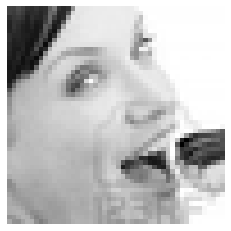

In [10]:
#plotting one image
plt.imshow(X[34].reshape(48,48),cmap='gray', vmin=0, vmax=255) #48x48 grayscale
plt.axis('off')

## Transform Data

Train Test Split

In [11]:
# train test split

enc = OneHotEncoder(sparse=False) # label data has to be in that format for keras
Y = enc.fit_transform(Y.reshape(-1,1))
X = X.reshape(len(X),48,48,1) # data has to be in that format for keras


X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state=SEED, stratify=Y)

# For tuning the model parameters we probably have to implement an optimization
# method (bayesian, random search, genetic) and maybe Cross-Validation. 
# This was just for making the first couple steps.

In [12]:
print('Shape X_train: %s, Shape y_train: %s' % (X_train.shape, y_train.shape))
print('Shape X_test: %s, Shape y_test: %s' % (X_test.shape, y_test.shape))

Shape X_train: (31806, 48, 48, 1), Shape y_train: (31806, 6)
Shape X_test: (3534, 48, 48, 1), Shape y_test: (3534, 6)


Split Training Data for: Train and validation data

In [13]:
data_train, data_val, data_train_y, data_val_y = train_test_split(X_train, y_train, train_size=0.8, random_state=SEED, stratify=y_train)

data_train = data_train.reshape(len(data_train), 48, 48)
data_val = data_val.reshape(len(data_val), 48, 48)

Data Augmentation

In [14]:
X_train_RGB = np.repeat(data_train[..., np.newaxis], 3, -1)
X_val_RGB = np.repeat(data_val[..., np.newaxis], 3, -1)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0.1,  
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale = 1./255,
    )

# Rescaling for validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Model Training

Callbacks and hyperparameter

In [15]:
# Callbacks for model training
model_name = 'model'
save_path = '/content/drive/MyDrive/AI project/models_new/mc/'
INPUT_SHAPE = X_train[0].shape
OUTPUT_SHAPE = Y.shape[1]
optimizer = Adam(learning_rate=0.0001)
EPOCHS = 50
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(#save_path + 
                             model_name,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
earlystopper = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.00001)

callbacks = [earlystopper, 
             checkpoint, reduce_lr]

## Third model - with best hyperparameters and dropout

In [16]:
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import cv2, numpy as np

model = Sequential()
# Input Layer
model.add(Conv2D(160, (3, 3), activation='relu', padding="same", 
                 input_shape = (48,48,3)))

#Block 1
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
model.add(Dropout(0.1))

# Block 2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(224, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(160, (3, 3), padding="same", activation='relu'))
model.add(Dropout(0.1))

# Block 3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(192, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Dropout(0.1))

# Block 4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(160, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# Dense layers
model.add(Dense(96, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(6 , activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 160)       4480      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 96)        138336    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 96)        83040     
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 96)        0

In [17]:
# choosing optimizer and compiling
model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics = ['accuracy'])


# model training
model_history = model.fit(train_datagen.flow(X_train_RGB, data_train_y, batch_size=BATCH_SIZE),
                          steps_per_epoch=len(X_train_RGB)/BATCH_SIZE, 
                          epochs=EPOCHS, verbose=1, callbacks=callbacks,
                          validation_data=test_datagen.flow(X_val_RGB, data_val_y),
                          validation_steps=len(X_val_RGB)//BATCH_SIZE
                          )

Epoch 1/50
795/795 [==============================] - 75s 35ms/step - loss: 1.7668 - accuracy: 0.2545 - val_loss: 1.7536 - val_accuracy: 0.2546

Epoch 00001: val_loss improved from inf to 1.75356, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 2/50
795/795 [==============================] - 27s 34ms/step - loss: 1.7495 - accuracy: 0.2545 - val_loss: 1.6858 - val_accuracy: 0.2910

Epoch 00002: val_loss improved from 1.75356 to 1.68575, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 3/50
795/795 [==============================] - 27s 33ms/step - loss: 1.6479 - accuracy: 0.3166 - val_loss: 1.5976 - val_accuracy: 0.3414

Epoch 00003: val_loss improved from 1.68575 to 1.59757, saving model to model
INFO:tensorflow:Assets written to: model/assets
Epoch 4/50
795/795 [==============================] - 26s 33ms/step - loss: 1.5356 - accuracy: 0.3615 - val_loss: 1.4773 - val_accuracy: 0.3902

Epoch 00004: val_loss improved from 1.59757 to

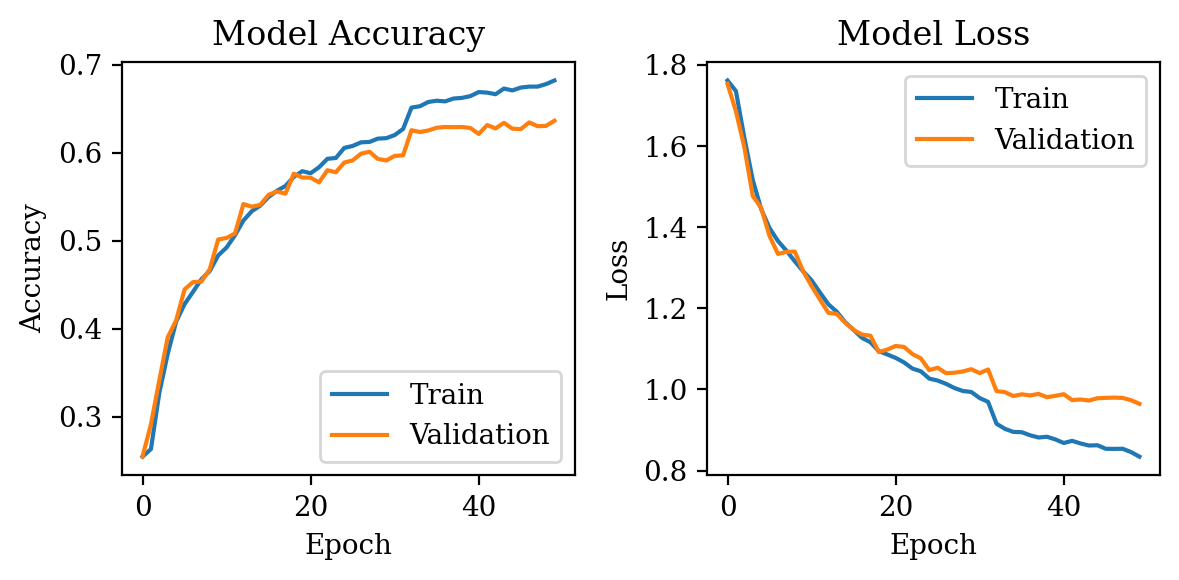

In [18]:
model_training_viz(model_history)



              precision    recall  f1-score   support

           0       0.56      0.60      0.58       495
           2       0.48      0.36      0.41       512
           3       0.86      0.88      0.87       899
           4       0.53      0.52      0.52       608
           5       0.77      0.76      0.76       400
           6       0.57      0.64      0.60       620

    accuracy                           0.65      3534
   macro avg       0.63      0.63      0.62      3534
weighted avg       0.64      0.65      0.64      3534



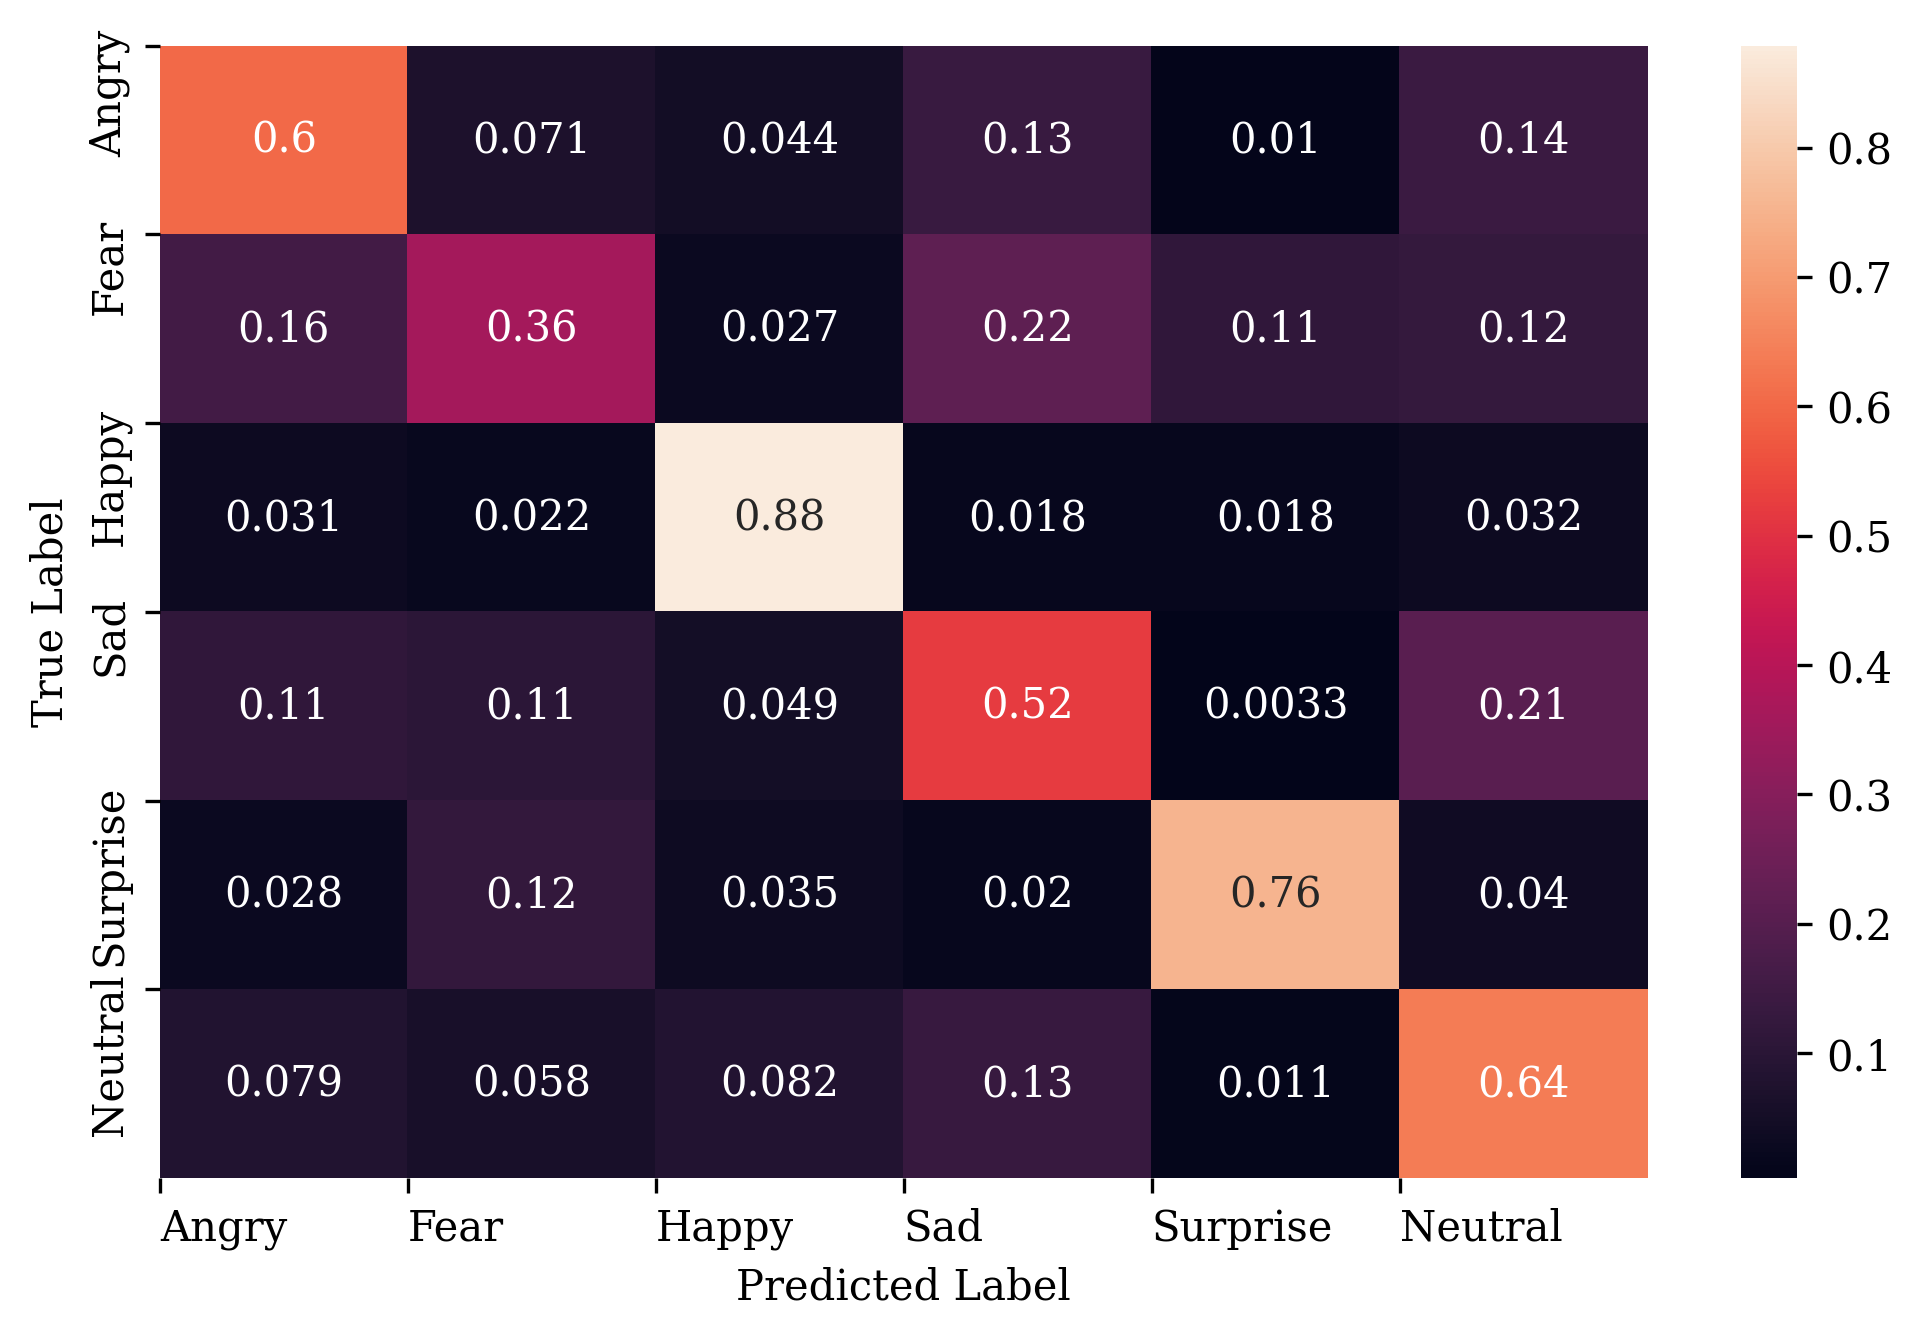

In [19]:
X_test_scaled = X_test/255
data_test = X_test_scaled.reshape(len(X_test), 48, 48)
X_test_RGB = np.repeat(data_test[..., np.newaxis], 3, -1)

evaluate_model(X_test_RGB, y_test, model)
plt.savefig('/content/drive/MyDrive/AI project/models' + '_conf_matrix1')

# Emotion detection opencv

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

face_classifier=cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
classifier = load_model('/content/drive/MyDrive/AI project/models/model')

class_labels=['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
cap=cv2.VideoCapture("/content/drive/MyDrive/AI project/Videos for testing/WIN_20210525_12_48_40_Pro.mp4")
img_array = []

while True:
    ret,frame=cap.read()
    if ret == False:
      break
    labels=[]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray=gray[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi=roi_gray.astype('float')/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)
            roi = np.repeat(roi, 3, -1)
            preds=classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position=(x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,20),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,0),3)
    
    img_array.append(frame)

result = "/content/drive/MyDrive/AI project/Videos for testing/vid_out_final.avi"
frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
vid = cv2.VideoWriter(result,fourcc,30,(frame_width,frame_height))

for i in range(len(img_array)):
    vid.write(img_array[i])
vid.release()
cap.release()
cv2.destroyAllWindows()